In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from itertools import *
import pandas as pd
from collections import defaultdict

In [2]:
from collections import defaultdict

In [3]:
alpha = 0.55
h = 100
top = h**alpha
def sample_displacement():
    u = rnd.random()
    return (-((u * (top - 1) - top) / top))**(-1/alpha)

In [4]:
beta = 0.8
h = 17
top2 = h**beta
def sample_delay():
    u = rnd.random()
    return (-((u * (top2 - 1) - top2) / top2))**(-1/beta)

In [5]:
def sample_numhops():
    i = 0
    h = 0
    while h < 24 * 30: 
        i += 1
        h += sample_delay()
    return i

In [85]:
rho = 0.6
gamma = 0.21

def walkers(n):
    cells = [defaultdict(int) for _ in range(n)]
    homes = [rnd.uniform(0, 99, 2) for _ in range(n)]
    for i in range(n):
        visits = [1.0]
        S = 1
        pos = homes[i]
        visited = [pos]
        loc = S
        for _ in range(sample_numhops() + 1):
            cells[i][tuple(np.trunc(pos))] += 1
            if rnd.random() < rho * S ** -gamma:
                visits.append(1)
                S += 1
                loc = S
                theta = rnd.rand() * 2 * np.pi
                r = sample_displacement()
                h = np.array([np.cos(theta), np.sin(theta)])
                pos = pos + h * r
                visited.append(pos)
            else:
                va = np.array(visits)
                loc = rnd.choice(S, p=va / va.sum())
                visits[loc] += 1
                pos = visited[loc]
    freqcells = defaultdict(lambda: defaultdict(int))
    avgdist = defaultdict(int)
    freqcounts = defaultdict(int)
    for i in range(n):
        for k,v in cells[i].items():
            diff = np.array(k) - homes[i]
            dist = np.trunc(np.sqrt(diff.dot(diff)))
            freqcells[v][dist] += 1
            avgdist[v] += dist
            freqcounts[v] += 1
    return freqcells, avgdist, freqcounts

In [ ]:
# the average distance traveled per visit for each frequency

In [93]:
cells, dists, counts = walkers(4000)

In [94]:
avgdists = [v / counts[k] for k,v in dists.items()]
freqs = list(dists.keys())
    

In [ ]:
# Let's get the cumulative distribution of people visiting from within radius r for various frequencies.
# Start with frequency -> dist -> number of people. That's what freqcells has. 

<IPython.core.display.Javascript object>


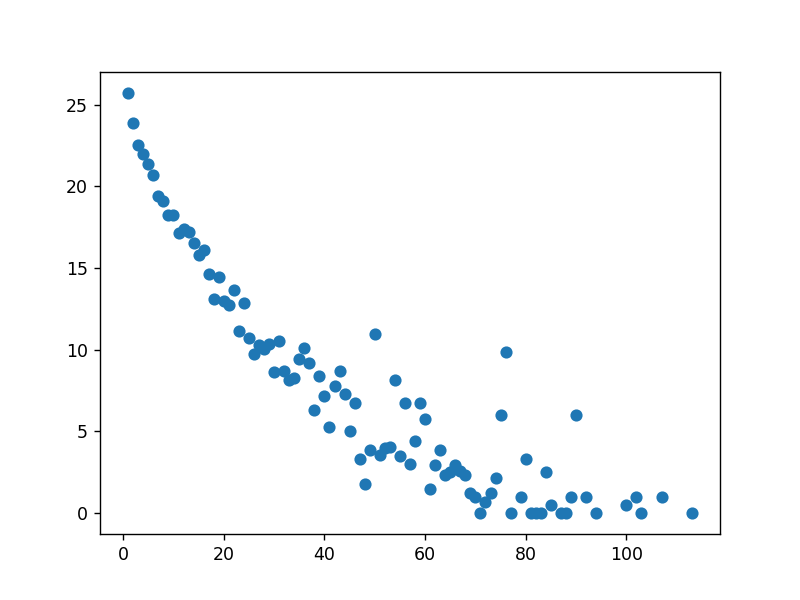

In [95]:
plt.plot(freqs, avgdists, 'o')

<IPython.core.display.Javascript object>


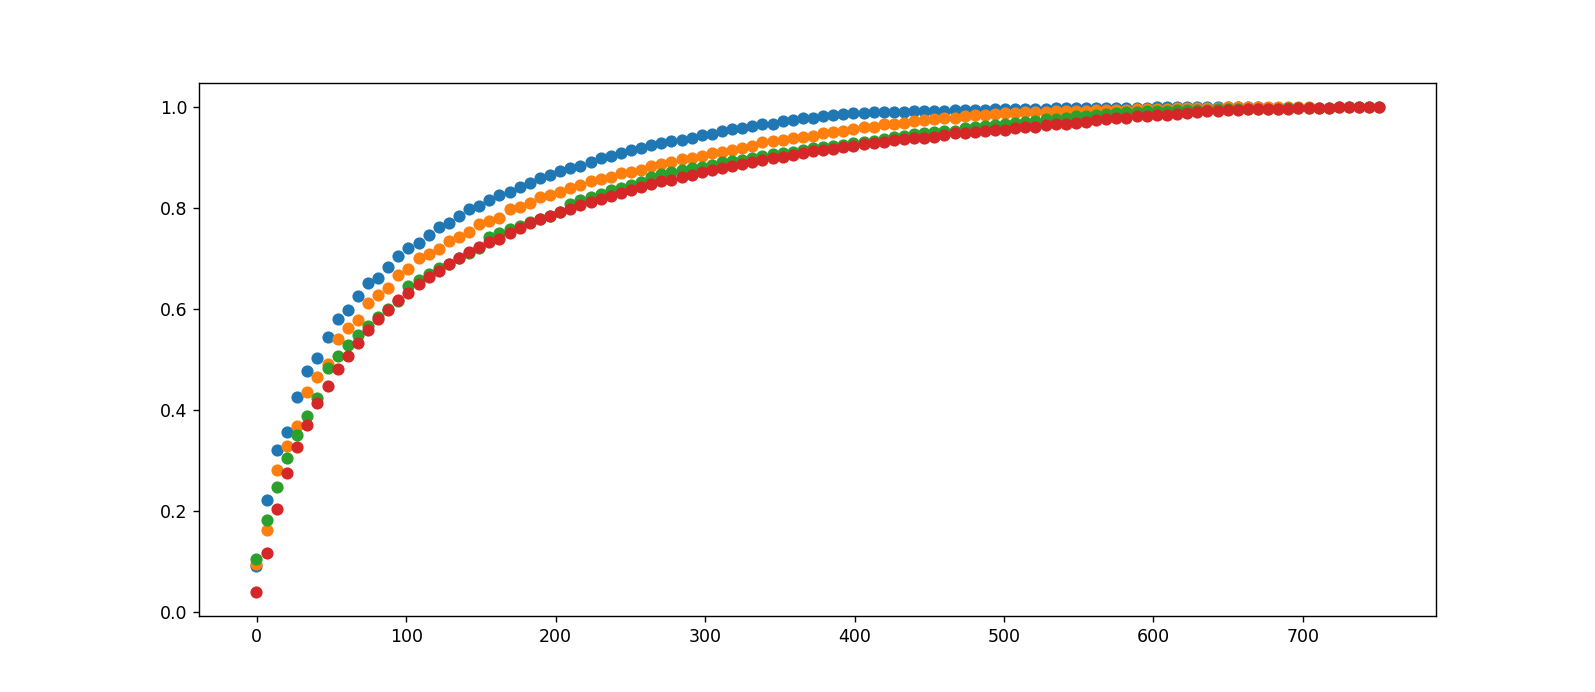

In [117]:
bins = 120
for f in range(4,8):
    s = pd.Series(cells[f])
    bvc, bins = pd.cut(s.index*f, bins, retbins=True, labels=False)
    vc = s.groupby(bvc).sum()
    total = vc.sum()
    cdf = vc.cumsum()
    plt.plot(bins[:len(cdf)], cdf / total, 'o')

<IPython.core.display.Javascript object>


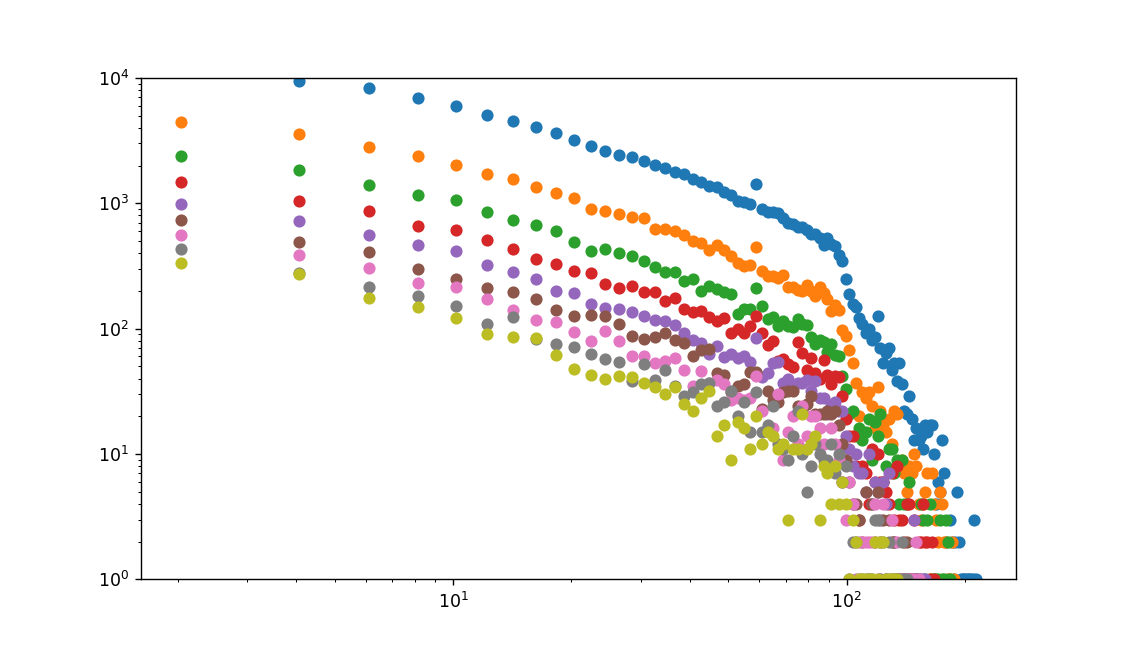

In [122]:
bins = 120
for f in range(1,10):
    s = pd.Series(cells[f])
    bvc, bins = pd.cut(s.index, bins, retbins=True, labels=False)
    vc = s.groupby(bvc).sum()
    plt.loglog(bins[:len(vc)], vc, 'o')
    plt.ylim([1, 10000])

In [55]:
?s.groupby